In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json

import sys
sys.path.append('../0 utils/')
from tool import *

data_root = '../../MyData/'

## Load data

In [2]:
item1_embedding = pd.read_csv(data_root+'merged_1197.csv')
item1_embedding = item1_embedding[['cik', 'tic', 'Year', 'item1_embeddings']]
print(len(item1_embedding))
print(item1_embedding.head())

other_embedding = pd.read_csv(data_root+'output_embeddings_2.csv')
other_embedding = other_embedding[['cik', 'SP_SHORT_DESC_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']]
print(len(other_embedding))
print(other_embedding.head())

total_embedding = pd.merge(item1_embedding, other_embedding, on=['cik'])

# To reduce mem consumption
item1_embedding = ''
other_embedding = ''

print(len(total_embedding))
total_embedding.head()

1197
       cik   tic  Year                                   item1_embeddings
0   850460  WIRE  2021  [0.03955410048365593, -0.04159577935934067, -0...
1   352541   LNT  2021  [-0.0231856107711792, 0.001279839314520359, 0....
2  1704715   AMR  2021  [0.014074714854359627, 0.006938479840755463, 0...
3  1575515   SFM  2021  [-0.023708730936050415, 0.01762891560792923, 0...
4  1125376  ENSG  2021  [0.04463111609220505, 0.0018805989529937506, 0...
1197
       cik                           SP_SHORT_DESC_embeddings  \
0   850460  [0.01568225771188736, -0.07636360824108124, -0...   
1   352541  [-0.013836896046996117, -0.028995024040341377,...   
2  1704715  [0.0030535957776010036, 0.0008783274097368121,...   
3  1575515  [-0.025762900710105896, 0.0034106436651200056,...   
4  1125376  [0.04616139456629753, -0.0021259395871311426, ...   

                             SP_LONG_DESC_embeddings  \
0  [0.06089901179075241, -0.07059630751609802, -0...   
1  [-0.021961161866784096, 0.02030270546674

,cik,tic,Year,item1_embeddings,SP_SHORT_DESC_embeddings,SP_LONG_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,"[0.03955410048365593, -0.04159577935934067, -0...","[0.01568225771188736, -0.07636360824108124, -0...","[0.06089901179075241, -0.07059630751609802, -0...",NaN,NaN
1,352541,LNT,2021,"[-0.0231856107711792, 0.001279839314520359, 0....","[-0.013836896046996117, -0.028995024040341377,...","[-0.021961161866784096, 0.020302705466747284, ...","[-0.015400929376482964, 0.03232719004154205, -...","[-0.041709959506988525, -0.011898815631866455,..."
2,1704715,AMR,2021,"[0.014074714854359627, 0.006938479840755463, 0...","[0.0030535957776010036, 0.0008783274097368121,...","[-0.0017570963827893138, 0.006557094398885965,...","[-0.02030838653445244, -0.009386725723743439, ...","[-0.012340557761490345, -0.01428779773414135, ..."
3,1575515,SFM,2021,"[-0.023708730936050415, 0.01762891560792923, 0...","[-0.025762900710105896, 0.0034106436651200056,...","[-0.015190708450973034, 0.011541897431015968, ...","[-0.013177500106394291, 0.036401789635419846, ...","[-0.01883152313530445, 0.021741388365626335, 0..."
4,1125376,ENSG,2021,"[0.04463111609220505, 0.0018805989529937506, 0...","[0.04616139456629753, -0.0021259395871311426, ...","[0.05935207009315491, 0.0013673527864739299, 0...","[0.029405493289232254, 0.014010551385581493, 0...","[-0.006068837363272905, 0.010537531226873398, ..."


### Check dataset

In [3]:
nan_proportion = total_embedding.isna().mean()
print(f"The nan value proportion in each column:\n{nan_proportion}\n\n")

The nan value proportion in each column:
cik                           0.000000
tic                           0.000000
Year                          0.000000
item1_embeddings              0.000000
SP_SHORT_DESC_embeddings      0.041771
SP_LONG_DESC_embeddings       0.095238
ORBIS_PROD_SERV_embeddings    0.208020
ORBIS_OVERVIEW_embeddings     0.168755
dtype: float64




## Define fusion function

In [4]:
def concatenate_fusion(data_df, target_list):
    modality_content_list = []
    for target in target_list:
        temp_list = list(data_df[target].apply(json.loads))
        modality_content_list.append(temp_list)

    modality_content_array = np.array(modality_content_list)  # Shape: (3, 1197, 1536)

    arr_transposed = np.transpose(modality_content_array, (1, 0, 2))  # Shape: (1197, 3, 1536)
    arr_shape = arr_transposed.shape

    # Reshape the last two dimensions into a single dimension
    result = arr_transposed.reshape(arr_shape[0], arr_shape[1]*arr_shape[2])
    
    return result

## Experiment 1:

Concatenate item1, sp_long, orbis_overview

### concatenate

In [5]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year']
exp1_df = total_embedding[info_list + target_list]
exp1_df = exp1_df.dropna(how='any')

concatenated_np = concatenate_fusion(exp1_df, target_list)
print(concatenated_np.shape)
concatenated_np

(926, 4608)


array([[-0.02318561,  0.00127984,  0.03837442, ..., -0.01639827,
        -0.00884627,  0.01504294],
       [ 0.01407471,  0.00693848,  0.05793545, ..., -0.01053198,
        -0.01884542,  0.01698861],
       [-0.02370873,  0.01762892,  0.03881923, ...,  0.00984779,
         0.01709069, -0.00222528],
       ...,
       [-0.02168068,  0.02275101,  0.01675978, ...,  0.00697548,
         0.00930723, -0.00699524],
       [ 0.02060029,  0.01415954,  0.02986284, ...,  0.00881959,
        -0.01525622, -0.00635244],
       [-0.06847923, -0.00438687,  0.04645469, ..., -0.0006741 ,
        -0.00551236,  0.0016899 ]])

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
embedding_pca = pca.fit_transform(concatenated_np)

print(embedding_pca.shape)
embedding_pca


(926, 256)


array([[-0.02951937,  0.60677675, -0.0444517 , ...,  0.01577879,
         0.02037527, -0.03166496],
       [-0.19228099,  0.52200905,  0.03247987, ...,  0.01423553,
         0.01817401,  0.0379433 ],
       [ 0.05693693, -0.24082623,  0.36334466, ..., -0.01272986,
         0.05680642, -0.01534579],
       ...,
       [-0.28189837,  0.2264416 , -0.07304576, ...,  0.02299418,
         0.04065928,  0.06630217],
       [ 0.13300188, -0.07663488,  0.10693204, ...,  0.04145098,
         0.00264292, -0.05638222],
       [ 0.23650937,  0.02315971,  0.10912942, ...,  0.00168169,
        -0.00568777, -0.02029505]])

In [7]:
exp1_df = exp1_df[['cik', 'tic', 'Year']]

exp1_df['cluster_10'] = cluster(embedding_pca, 10)
exp1_df['cluster_100'] = cluster(embedding_pca, 100)
exp1_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.004358737371641933
Normalized Within-Cluster Sum of Squares (WCSS): 0.003113986167803447


,cik,tic,Year,cluster_10,cluster_100
1,352541,LNT,2021,6,8
2,1704715,AMR,2021,8,16
3,1575515,SFM,2021,0,58
4,1125376,ENSG,2021,9,87
5,1674335,JELD,2021,4,20
...,...,...,...,...,...
1190,1653653,RRR,2021,2,60
1191,1627223,CC,2021,4,43
1192,1021860,NOV,2021,1,74
1193,1744489,DIS,2021,3,68


In [10]:
# exp1_df.to_csv('3_pca_clusters.csv', index=False)

### Evaluate

In [8]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
# returns_long = fetch_stock_data(exp1_df, year, mode)
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp1_returns = pd.merge(exp1_df, returns_long, on='tic', how='inner')

exp1_intra_corrs_10 = intra_industry_correlations(exp1_returns, "cluster_10")
exp1_avg_intra_corr_10 = np.nanmean(list(exp1_intra_corrs_10.values()))
print(exp1_avg_intra_corr_10)

exp1_intra_corrs_100 = intra_industry_correlations(exp1_returns, "cluster_100")
exp1_avg_intra_corr_100 = np.nanmean(list(exp1_intra_corrs_100.values()))
print(exp1_avg_intra_corr_100)

print(len(exp1_returns['cik'].unique()))

0.37943640018266606
0.4386297485235221
924


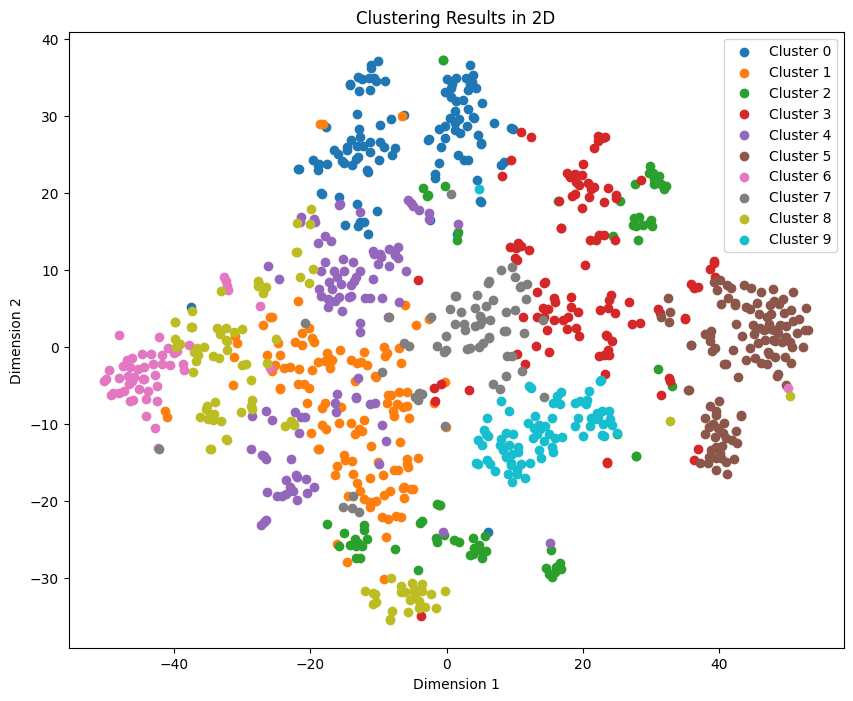

In [9]:
show_cluster_graph(embedding_pca, exp1_df['cluster_10'])

## Experiment 0

In [77]:
returns_long = pd.read_csv(data_root+"returns_long.csv")

returns_long = returns_long.dropna(how='any')

result = returns_long.groupby("tic")["Return"].apply(list).reset_index()
result['len'] = result['Return'].apply(len)
result = result[result['len'] == 500]

result_array = list(result['Return'])
print(type(result_array))

<class 'list'>


In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=100)
# embedding_pca = pca.fit_transform(result_array)

# print(embedding_pca.shape)
# embedding_pca

(1062, 100)


array([[-1.24225168e-01, -8.82672607e-02, -7.41272485e-02, ...,
         3.24565881e-02,  7.72384117e-02, -6.22050066e-02],
       [-1.30756091e-01, -9.36989656e-02, -4.57287371e-02, ...,
         1.61511406e-02, -1.74252258e-02, -1.53707652e-03],
       [-1.27378275e-01, -6.16099512e-02, -5.18869149e-02, ...,
         6.61727011e-03,  2.49891764e-03, -5.03779398e-03],
       ...,
       [-1.86962682e-01, -7.19387360e-02, -5.65361779e-02, ...,
        -2.17128906e-03, -2.85459049e-02,  2.48342142e-02],
       [-1.37555947e-01, -7.32284644e-02, -2.95131371e-02, ...,
         4.18564887e-02, -1.09386915e-02,  1.10611049e-02],
       [ 2.55808216e+00, -6.48085127e-01,  7.60346824e-03, ...,
        -7.49281239e-04,  2.01638573e-05, -1.59247418e-03]])

In [89]:
exp0_df = total_embedding[total_embedding['tic'].isin(result['tic'].to_list())]

In [90]:
exp0_df = exp0_df[['cik', 'tic', 'Year']]

exp0_df['cluster_10'] = cluster(result_array, 10)
exp0_df['cluster_100'] = cluster(result_array, 100)
exp0_df

Cluster Labels: [8 4 9 ... 4 9 7]
Cluster Centers: [[ 1.29873127e-02 -4.39008599e-02  7.04670218e-03 ...  3.52971807e-03
   2.75632170e-03 -1.65102926e-02]
 [-1.37184072e-01 -2.09205810e-02 -3.41880028e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.24999987e-01  0.00000000e+00  0.00000000e+00 ...  2.33333349e-01
  -2.81081067e-01 -2.25564584e-02]
 ...
 [ 1.42857009e-02 -2.11267411e-02 -5.75539883e-02 ...  1.00000000e+00
   0.00000000e+00  5.00000109e-01]
 [ 2.29870168e-02 -1.94289199e-02  1.97637485e-02 ... -3.33538779e-03
  -1.42875945e-02 -8.71229436e-03]
 [ 2.14317667e-03 -9.88056899e-03 -1.34013712e-03 ...  1.31230990e-04
   2.37285697e-03 -2.52048926e-03]]
Within-Cluster Sum of Squares (WCSS): 254.17766735503557
Cluster Labels: [17 97 74 ... 20 74  5]
Cluster Centers: [[ 0.02737137 -0.04057568 -0.01133098 ...  0.02627826  0.00306153
  -0.02303002]
 [-0.13718407 -0.02092058 -0.034188   ...  0.          0.
   0.        ]
 [ 0.12499999  0.          0.         ...  0.

,cik,tic,Year,cluster_10,cluster_100
1,352541,LNT,2021,8,17
2,1704715,AMR,2021,4,97
3,1575515,SFM,2021,9,74
4,1125376,ENSG,2021,9,22
5,1674335,JELD,2021,4,79
...,...,...,...,...,...
1190,1653653,RRR,2021,6,74
1191,1627223,CC,2021,4,17
1192,1021860,NOV,2021,4,20
1193,1744489,DIS,2021,9,74


In [91]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
# returns_long = fetch_stock_data(exp0_df, year, mode)
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp0_returns = pd.merge(exp0_df, returns_long, on='tic', how='inner')

exp0_intra_corrs_10 = intra_industry_correlations(exp0_returns, "cluster_10")
exp0_avg_intra_corr_10 = np.nanmean(list(exp0_intra_corrs_10.values()))
print(exp0_avg_intra_corr_10)

exp0_intra_corrs_100 = intra_industry_correlations(exp0_returns, "cluster_100")
exp0_avg_intra_corr_100 = np.nanmean(list(exp0_intra_corrs_100.values()))
print(exp0_avg_intra_corr_100)

print(len(exp0_returns['cik'].unique()))

0.30961877075784905
0.30914038864873067
1062


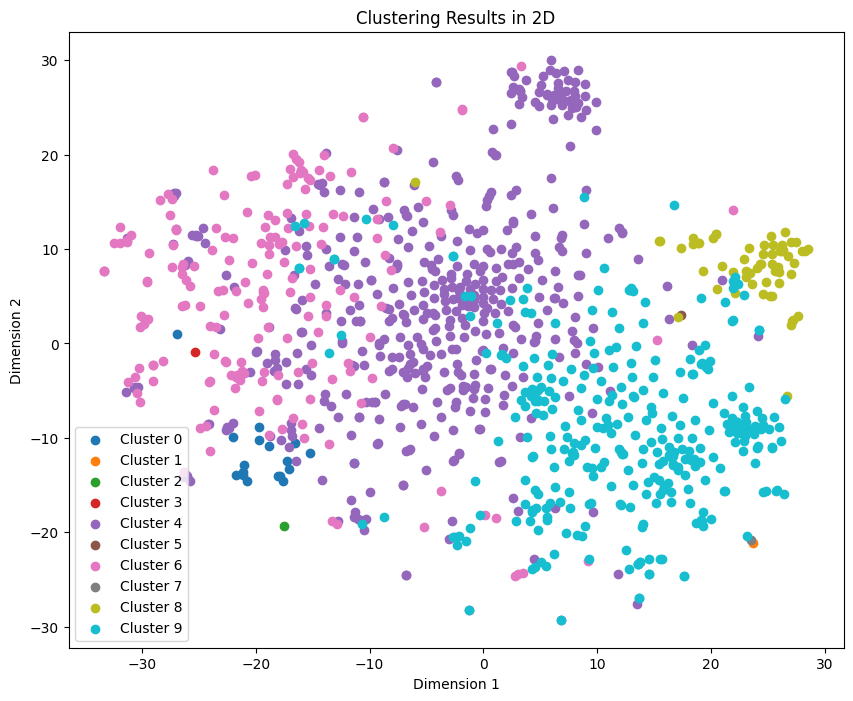

In [88]:
show_cluster_graph(np.array(result_array), exp0_df['cluster_10'])